# ResNet 50 Implementation

## Importing Libraries

In [1]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

2023-05-05 16:52:24.954033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Defining Model Parameters

In [2]:
train_path = "fmd dataset/Train"
test_path = "fmd dataset/Test"
val_path = "fmd dataset/Validation"

seed = 0
image_size = 100
channels = 3
validation_split = 0.2
batch_size = 32
num_epochs = 30
learning_rate = 0.00001
early_stop_patience = 10
classes = ['WithMask', 'WithoutMask']

## Retrieving training, validation and test datasets

In [3]:
train = image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True
)

validation = image_dataset_from_directory(
    directory=val_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=False
)

Found 10000 files belonging to 2 classes.


2023-05-05 16:52:26.965039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


2023-05-05 16:52:26.981892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 16:52:26.982513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 16:52:26.984496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Model Architecture

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
input_tensor = tf.keras.layers.Input(shape=(image_size, image_size, channels))
model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_tensor=input_tensor,
    include_top=False,
    pooling='avg',
    classes=2,
)

# Apply CNN Headers on top of the base model
xin = model.output
xout = Dense(512, activation="relu")(xin)
xout = Dropout(0.2)(xout)
xout = Dense(256, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(128, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(64, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(32, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(16, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(8, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(4, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(2, activation="relu")(xout)
xout = Dropout(0.2)(xout)
xout = Dense(len(classes), activation='softmax')(xout)

detector = Model(inputs=model.input, outputs=xout)

early_stopping = EarlyStopping( monitor="val_loss", mode="min", verbose=1, restore_best_weights=True)

In [6]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

## Checking Cudas

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Training on Cudas if available

In [8]:
optimizer = Adam(learning_rate=learning_rate)
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

In [9]:
with tf.device('/GPU:0'):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    dmodel = model.fit(train, validation_data=validation, epochs=num_epochs)

Epoch 1/30


2023-05-05 16:52:30.860192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:52:30.860414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 16:52:39.430796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-05 16:52:39.954457: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-05 16:52:41.362049: I tensorflow/compiler/xl

313/313 [==============================] - ETA: 0s - loss: 8.3868 - sparse_categorical_accuracy: 0.0000e+00

2023-05-05 16:53:08.840494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [800]
	 [[{{node Placeholder/_0}}]]
2023-05-05 16:53:08.840713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [800]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:53:09.421996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 39s 41ms/step - loss: 8.3868 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 8.2525 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/30
313/313 [==============================] - 11s 36ms/step - loss: 7.2426 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 7.1498 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/30
313/313 [==============================] - 11s 35ms/step - loss: 6.7970 - sparse_categorical_accuracy: 1.0000e-04 - val_loss: 6.6775 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/30
313/313 [==============================] - 12s 39ms/step - loss: 6.5087 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 6.4895 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/30
313/313 [==============================] - 12s 38ms/step - loss: 6.3100 - sparse_categorical_accuracy: 1.0000e-04 - val_loss: 6.2955 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/30
313/313 [==============================] - 13s 40m

## Plotting training progress

<Axes: >

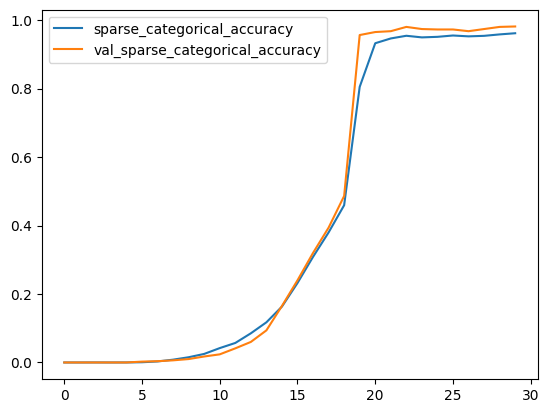

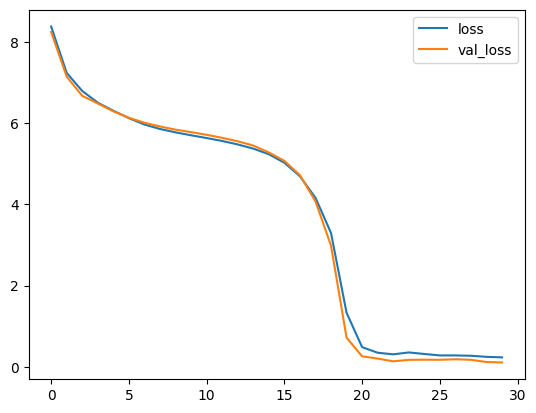

In [10]:
loss_curve = pd.DataFrame(dmodel.history)

loss_curve[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
loss_curve[["loss", "val_loss"]].plot()

## Predict from the above trained model

In [12]:
y_true = []
y_pred = []

for x_test_batch, y_test_batch in test:
    y_true.append(y_test_batch)
    predictions = detector.predict(x_test_batch, verbose=0)
    y_pred.append(np.argmax(predictions, axis=1))

y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

## Evaluation of Model

In [13]:
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

              precision    recall  f1-score   support

    WithMask     0.4869    1.0000    0.6549       483
 WithoutMask     0.0000    0.0000    0.0000       509

    accuracy                         0.4869       992
   macro avg     0.2434    0.5000    0.3275       992
weighted avg     0.2371    0.4869    0.3189       992



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


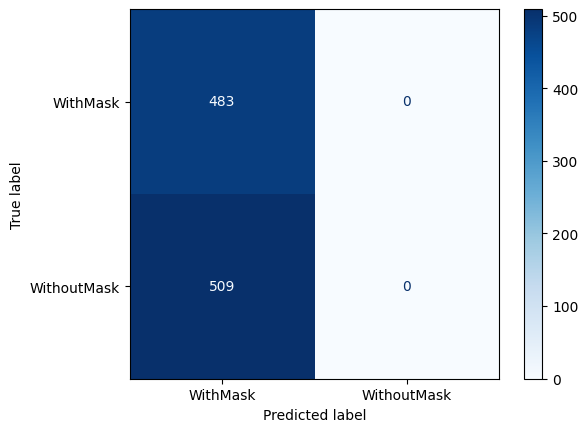

In [14]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Optimizing the model for Embedded Systems and Mobile Phones using TensorFlow Lite

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('ResNet50.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfj8ifc2q/assets


INFO:tensorflow:Assets written to: /tmp/tmpfj8ifc2q/assets
2023-05-05 16:59:25.944473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-05 16:59:25.944519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-05 16:59:25.944873: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfj8ifc2q
2023-05-05 16:59:25.964929: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-05 16:59:25.964953: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfj8ifc2q
2023-05-05 16:59:26.029559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-05 16:59:26.053422: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-05 16:59:26.835188: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [17]:
# Use the model
interpreter = tf.lite.Interpreter(model_path='ResNet50.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 100, 100,   3], dtype=int32), 'shape_signature': array([ -1, 100, 100,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 182, 'shape': array([   1, 2048], dtype=int32), 'shape_signature': array([  -1, 2048], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[ 22.14096  178.12244    0.       ...  82.667496   1.431867  41.787247]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
